## **Data Wrangling**

**User engagement data**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
%matplotlib inline
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Read the user engagement data
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
#Check how many users and how many logins
print('There were {} users and {} total logins'.format(
    engagement['user_id'].nunique(), len(engagement)
))

There were 8823 users and 207917 total logins


In [4]:
# Convert time_stamp into datetime format
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [5]:
# Define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # Drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # Calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # Check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [6]:
# Run the function on all users
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [7]:
print('There were {} adopted users out of {} users'.format(
    sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


**User data**

In [8]:
# Read the user data
# Some columns such as name, email address are not useful here
# Let's not read them in
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv('takehome_users.csv', usecols=cols)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


There were likely that there were too many organizations and user invites to model. Let's do a quick survey of organizations with the most users and users who sent out most invites. Then we drop those two features.

In [9]:
# 5 Organizations with most users
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [10]:
# 5 Users with most invites
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
Name: invited_by_user_id, dtype: int64

In [11]:
# remove those two features
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

From creation time and last session time, we can engineer two features that can be useful. It is possible that the history of using the service might be a factor of becoming "adopted users". In other words, users who have used the service for a long time might be more likely as "adopted users" than those who just signed up. It is likely that user adoption rate vary through time, so it is useful to take a look at account age (based on creation time) as well.

In [12]:
# Create feature for user history
# Convert both time features into datetime
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')

# Calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

# Calculate account age, defined as number of days since account creation and now
# Not sure when this dataset was collected. Let's use latest date in creation_time
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days

# Drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [13]:
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,0.0,38
1,2,ORG_INVITE,0,0,136.0,196
2,3,ORG_INVITE,0,0,0.0,437
3,4,GUEST_INVITE,0,0,1.0,374
4,5,GUEST_INVITE,0,0,5.0,498


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


There were 8823 users who had "user history" out of 12000. Given there are users who has history of 0 days, I think engagement data for the other users were missing. So I will remove these users from the analysis.

In [15]:
# Merge user data and "adopted user" variable
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

## **Exploratory Data Analysis**

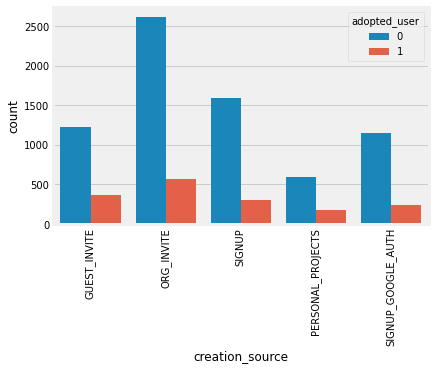

In [16]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [17]:
# Doesn't look like much difference among creation sources
# Let's do a chi2 test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [18]:
# chi2 test significant, but how much was the difference?
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

A slightly higher "adopted user" rate in guest_invite and personal_projects, which that makes sense because users who got invite probably was collaborating with others, and users who have personal projects are likely to have more personal interest that make them more engaged.


In [19]:
# Check mailing list and marketing drip
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [20]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148235, p = 0.4820695142048762


In [21]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

In [22]:
z_test(data, 'enabled_for_marketing_drip')

For enabled_for_marketing_drip, z = 0.40292649500940264, p = 0.6870022995069656


There was really no difference between users who signed up or not for mailing list and marketing drip.


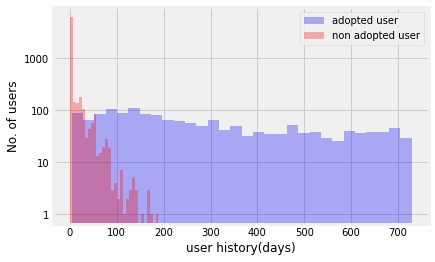

In [23]:
# History and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(data, 'history', 'user history(days)')

Pretty clear that users with long history are more likely to be adopted users.


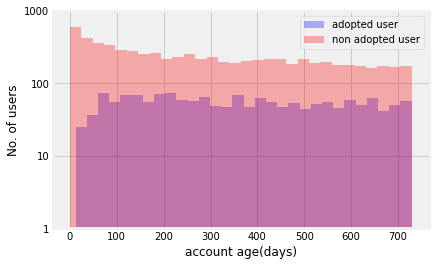

In [24]:
plot_hist_days(data, 'account_age', 'account age(days)')

The adoption rate is lower in very new accounts. Other than that, the adoption rate didn't change much over the past two years.


## **Predictive Modeling**

In [25]:
# Make dummy variable for creation source
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)
# Although account_age and history have different scales than other features,
# Planning to use random forest model, which is not affected by the different scales
# There is no need to scale the data
# Create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [26]:
# Use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 50}
Best average precision was 0.962521322728487


In [27]:
# Evaluation of model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9524025385312783
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [28]:
# Taking a look at feature importance
importance = pd.Series(model.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)
print(importance)

history                       0.896213
account_age                   0.088842
opted_in_to_mailing_list      0.003002
SIGNUP                        0.002919
enabled_for_marketing_drip    0.002682
ORG_INVITE                    0.002350
PERSONAL_PROJECTS             0.002069
SIGNUP_GOOGLE_AUTH            0.001923
dtype: float64


## **Conclusion and Recommendation**

The user history is the most important feature. Based on this, I recommend that an effective way of growing adopted users might be encouraging existing users to log in and use the service after they had accounts for a while.

The next important feature is how user signed up. Among the ways they sign up, guest invitation and personal projects are two categories with the highest user adoption rate. Encouraging users to invite others, and offering incentives for people to work on their personal projects using the service might be somewhat effective.
Account age has some importance, but there is nothing can be done to change that. Mailing list and marketing drip are not effective.
